In [1]:
using CSV
using DataFrames
using Statistics
using Random

using Plots
using Plots.PlotMeasures
using StatsPlots, KernelDensity

using NCBITaxonomy



In [3]:
#cd("/vf/users/saakyanh2/WD/fx/foldexity")
include("../src/fxio.jl")
include("../src/entropy.jl")
include("../src/foldexity.jl")



# Fold entropy

In [ ]:
scopdata = CSV.read("../data/astral.id", DataFrame, header=1)

ids = []
lineages = []

for (id, taxid) in zip(scopdata.id, scopdata.taxid)
    
    try
        push!(lineages, lineage(taxon(taxid)))
        push!(ids, id) 
    catch e
        println(e)
    end
end

In [5]:
domains = [taxid[3].name for taxid=lineages]

domaindata = DataFrame(id=ids, domain=domains)

e = "Eukaryota"
b = "Bacteria" 
a = "Archaea" 

size(domaindata)

(9724, 2)

In [6]:
foldseek3di = structure2fs3di("../../scop402")
select!(foldseek3di, Not([:coords]));
transform!(foldseek3di, :id => ByRow(s -> s[1:7]) => :id)
filter!(row -> all(col -> all(c -> !(c in col), ['X', 'B', 'Z']), row[[:seqaa, :seq3di]]), foldseek3di)
size(foldseek3di)


(9849, 3)

In [7]:
reseekmu = structure2rsmu("../../scop402")
transform!(reseekmu, :id => ByRow(s -> s[1:7]) => :id)
size(reseekmu)

(9852, 2)

In [10]:
# # will run for ~ 10 min
# dssp = structure2dssp("../../scop402")
# CSV.write("../data/dssp.csv",  dssp, writeheader=true)

dssp = CSV.read("../data/dssp.csv", DataFrame, header=1)
size(dssp)

(9839, 2)

In [8]:
k=12
foldseek3di[!,:H_SHaa ]   = mean.(entropy_profile.(shuffle_string.(foldseek3di.seqaa), k))
foldseek3di[!,:H_SH3Di ]  = mean.(entropy_profile.(shuffle_string.(foldseek3di.seq3di), k))
reseekmu[!,:H_SHmu ]   = mean.(entropy_profile.(shuffle_string.(reseekmu.seq), k))
dssp[!, :H_SHss] = mean.(entropy_profile.(shuffle_string.(dssp.ss), k))

foldseek3di[!,:H_aa ]   = mean.(entropy_profile.(foldseek3di.seqaa, k))
foldseek3di[!,:H_3Di ]  = mean.(entropy_profile.(foldseek3di.seq3di, k))
reseekmu[!,:H_mu ]   = mean.(entropy_profile.(reseekmu.seq, k))
dssp[!,:H_ss ]   = mean.(entropy_profile.(dssp.ss, k))




size(foldseek3di)

UndefVarError: UndefVarError: `dssp` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
# output = "../data/scop402fs4c1.tsv"
# fxdir("../../scop402", output, 3, "seq", 0.8)
# fx = CSV.read(output, DataFrame, delim = "\t") ; rm("fxdata.tsv")
# transform!(fx, :pdbpath => ByRow(s -> parse(Int, split(basename(s),".")[1])) => :id)
# sort!(fx, :id)
# fxseq = fx

# size(fx)

In [9]:
fxdata = CSV.read("../data/scop402fs4c15.tsv", DataFrame, delim="\t", header=1)

try
    transform!(fxdata, :pdbpath => ByRow(s -> basename(s)[1:7]) => :id) 
catch 
end
dropmissing!(fxdata)

fxdata = fxdata[(fxdata.aver_rmsd .> 0.1) .& (fxdata.aver_rmsd .< 5) ,:]


df = innerjoin(fxdata, foldseek3di, reseekmu, dssp, scopdata,  domaindata, on=:id)
df[!,:plen] = length.(df.seqaa)

df = df[!, [:id, :scop, :domain, :taxid, :plen, :fxity, :H_aa, :H_3Di, :H_mu, :H_ss, :H_SHaa, :H_SH3Di, :H_SHmu, :H_SHss, :seqaa, :seq3di]]


size(df)

UndefVarError: UndefVarError: `dssp` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

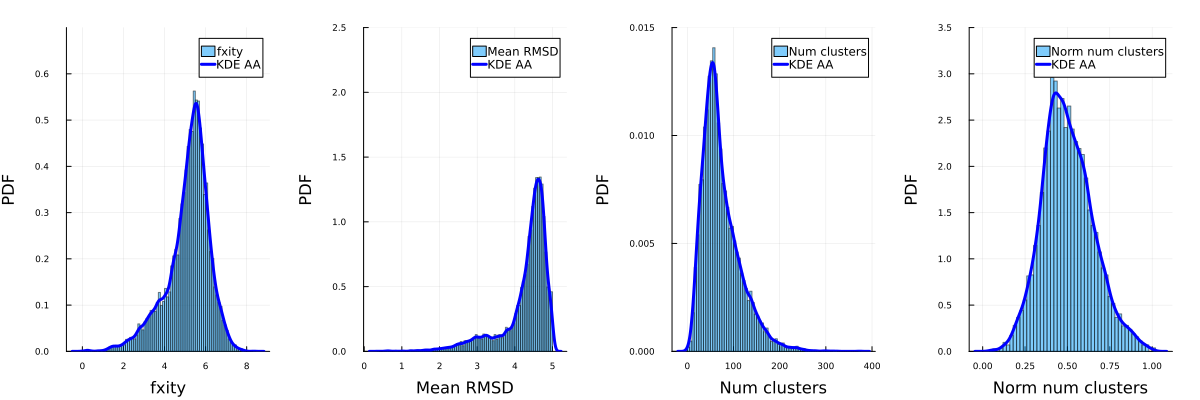

In [10]:
function plothist(aa, ylimit = (0, 1), label = "")
    alpha = 0.5
    p = histogram(aa,  xlabel=label, ylabel="PDF", normalize=:pdf, labels=label, alpha=alpha)
    p = plot!(kde(aa).x, kde(aa).density, linewidth=3, label="KDE AA", ylimit = ylimit, color=:blue)
    return p
end

p1 = plothist(fxdata[:, :fxity], (0, 0.7) ,"fxity")
p2 = plothist(fxdata[:, :aver_rmsd], (0, 2.5) , "Mean RMSD")
p3 = plothist(fxdata[:, :nclusts], (0, 0.015) , "Num clusters")
p4 = plothist(fxdata[:, :norm_nclusts], (0, 3.5) , "Norm num clusters")

plot(p1, p2, p3, p4, layout=(1, 4), size=(1200, 400), dpi=100, ytickfontsize=6, xtickfontsize=6, margins = 5mm)



In [ ]:
function scatter_corr(x, y)    
    s = scatter(x, y, label="R^2 = $(round(cor(x, y), sigdigits=2))", markershape=:circle, markersize = 2, alpha=0.5)
    return s
end


s1 = scatter_corr(df.H_aa, df.plen)
s2 = scatter_corr(df.H_3Di, df.plen)
s3 = scatter_corr(df.H_mu, df.plen)
s4 = scatter_corr(df.H_aa, df.H_3Di)
s5 = scatter_corr(df.H_aa, df.H_mu)
s6 = scatter_corr(df.H_3Di, df.H_mu)
s7 = scatter_corr(df.H_ss, df.H_aa)
s8 = scatter_corr(df.H_ss, df.H_mu)
s9 = scatter_corr(df.H_ss, df.H_3Di)


plot(s1, s2, s3, s4, s5, s6, s7, s8, s9, layout=(3, 3), size=(900, 700), dpi=500, margins = 4mm, ytickfontsize=6, xtickfontsize=6, 
    ylabel=["Protein length" "Protein length" "Protein length" "Entropy 3Di" "Entropy Mu" "Entropy Mu" "Entropy aa" "Entropy Mu" "Entropy 3Di"], 
    xlabel=["Entropy AA" "Entropy 3Di" "Entropy Mu" "Entropy AA" "Entropy AA" "Entropy 3Di" "DSSP" "DSSP" "DSSP"])

In [ ]:
function plothist(aa, fs3di, mu, ss)
    alpha = 0.5
    p = histogram([aa, fs3di, mu, ss], bins=50, xlabel="Entropy",  ylabel="PDF", normalize=:pdf, labels=["AA" "3Di" "Mu" "SS"], alpha=alpha)
    p = plot!(kde(aa).x, kde(aa).density, linewidth=3, label="KDE AA", color=:blue)
    p = plot!(kde(fs3di).x, kde(fs3di).density, linewidth=3, label="KDE 3Di", color=:orange)
    p = plot!(kde(mu).x, kde(mu).density, linewidth=3, label="KDE Mu", color=:green)
    p = plot!(kde(ss).x, kde(ss).density, linewidth=3, label="KDE Mu", color=:violet)
    return p
end

p1 = plothist(df[:, :H_aa], df[:, :H_3Di], df[:, :H_mu], df[:, :H_ss])
p2 = plothist(df[:, :H_SHaa], df[:, :H_SH3Di], df[:, :H_SHmu], df[:, :H_SHss])

plot(p1, p2, layout=(2, 1), size=(500,700), dpi=500, ytickfontsize=6, xtickfontsize=6, xlimit=(0, 3.5), margins = 5mm)


In [ ]:
elen = df[(df.domain .== e),:].plen
blen = df[(df.domain .== b),:].plen


function lengthhistogram(elen, blen, name="")
    h1 = histogram(elen, bins=50, label="euk", alpha=0.3, normalize=:pdf,)
    h1 = histogram!(blen, bins=50,  label="bac", alpha=0.3, normalize=:pdf,xlabel=name, ylabel="PDF", legend=:topright)
    h1 = plot!(kde(elen).x, kde(elen).density, linewidth=3, label="euk KDE", color=:blue)
    h1 = plot!(kde(blen).x, kde(blen).density, linewidth=3, label="bac KDE", color=:red)
    return h1
end

h1=lengthhistogram(elen, blen, "Length")


plot(h1,  margins = 5mm, dpi=100, size=(700,400), xtickfontsize=6, ytickfontsize=6, xlimit=(0, 900))

In [ ]:
H_Eaa = df[df.domain .== e,:].H_aa     
H_Baa = df[df.domain .== b,:].H_aa     
H_E3Di = df[df.domain .== e,:].H_3Di   
H_B3Di = df[df.domain .== b,:].H_3Di
H_Emu = df[df.domain .== e,:].H_mu
H_Bmu = df[df.domain .== b,:].H_mu   
H_Efx = df[df.domain .== e,:].fxity
H_Bfx = df[df.domain .== b,:].fxity   

In [ ]:
function entrohistogram(E, B, xname="")
    #h = histogram([E, B], bins=20, alpha=0.6, normalize=:pdf, ylabel="PDF", label=["Eukaryota" "Bacteria"])
    h = plot(kde(E).x, kde(E).density, linewidth=3, label=" Euk KDE ", color=:blue)
    h = plot!(kde(B).x, kde(B).density, linewidth=3, label=" Bac KDE ", color=:red, xlabel=xname)
    vline!(h, [mean(B)], lw=1, color="blue", label=" Median ", linestyle=:dash)
    vline!(h, [mean(E)], lw=1, color="red", label=" Median ", linestyle=:dash)
    return h
end




h1 = entrohistogram(H_Eaa, H_Baa, "AA")
h2 = entrohistogram(H_E3Di, H_B3Di, "3Di")
h3 = entrohistogram(H_Emu, H_Bmu, "Mu")
h4 = entrohistogram(H_Efx, H_Bfx, "Fxity")

plot(h1, h2, h3, h4, layout=(2,6), margins = 8mm, dpi=100, size=(1200,300),
    plot_title = "Shannon Entropy", xtickfontsize=6, ytickfontsize=6, legend=:topleft)

entrohistogram (generic function with 2 methods)

# 3Di vs AA

In [ ]:
k=1
seqAA = vcat(split2kmers.(foldseek3di.seqaa, k)...)
seq3Di = vcat(split2kmers.(foldseek3di.seq3di, k)...)
seqMu = vcat(split2kmers.(reseekmu.seq, k)...)
seqSS = vcat(split2kmers.(dssp.ss, k)...)


ab1 = seqSS
ab2 = seqMu

first(ab1,3)

In [20]:
alphabet1 = sort(unique(ab1))
alphabet2 = sort(unique(ab2))

seqlen = length(join(ab1))

alphabet_size1 = length(alphabet1)
alphabet_size2 = length(alphabet2)

mapdict1 = Dict{Any, Int}()
mapdict2 = Dict{Any, Int}()

for (i,j) = zip(alphabet1, 1:alphabet_size1)
    mapdict1[i] = j
end

for (i,j) = zip(alphabet2, 1:alphabet_size2)
    mapdict2[i] = j
end


token_pairs = [[i,j] for (i,j) = zip(ab1, ab2)]
counts = Dict{Any, Int}()

for pair in token_pairs
    counts[pair] = get(counts, pair, 0) + 1
end

In [21]:
m = Array{Float64}(undef, alphabet_size1, alphabet_size2)
for i = alphabet1
    for j = alphabet2
        try
            m[mapdict1[i], mapdict2[j]] = counts[[i, j]] / seqlen
        catch
            m[mapdict1[i], mapdict2[j]] = 0
        end
    end
end

In [ ]:
#Joint probability P(i, j) where i and j are letters in different alphabets
i,j = size(m)
heatmap(m, 
    color=:blues, 
    xlabel="3Di", ylabel="DSSP", 
    colorbar_title = "\nP(i,j)",
    
    grid=true, 
    xticks=(1:alphabet_size2, alphabet2), yticks=(1:alphabet_size1, alphabet1), 
    size=([j,i] * 30),  
    dpi=500, xrotation = 0, tickfontsize=8, margins = 5mm)

vline!(0.5:(j+0.5), c=:grey)
hline!(0.5:(i+0.5), c=:grey, legend=false)
#savefig("heatmap_3di_vs_AA.png")

# relative entropy of 2-mers

In [61]:
ALPHABET = foldseek3di.seqaa
#ALPHABET = foldseek3di.seq3di
#ALPHABET = reseekmu.seq
#ALPHABET = dssp.ss

seqaa1mers = vcat(split2kmers.(ALPHABET, 1)...)
seqaa2mers = vcat(split2kmers.(ALPHABET, 2)...)

len1mers = length(seqaa1mers)
len2mers = length(seqaa2mers)

alphabet = sort(unique(seqaa1mers))
alphabet_size = length(alphabet)

length(ALPHABET)

9849

In [62]:
prob1 = Dict{Any, Float64}()
for i in seqaa1mers
    try
        prob1[i] = get(prob1, i, 0) + 1
    catch 
        prob1[i] = 0
    end

end


In [63]:
prob2 = Dict{Any, Float64}()

for pair in seqaa2mers
    try
        prob2[pair] = get(prob2, pair, 0) + 1
    catch 
        prob2[pair] = 0
    end
end



In [64]:
for A in alphabet
    for B in alphabet
    pair = A * B
    try
        prob2[pair] = prob2[pair]
    catch 
        prob2[pair] = 0
    end
end
end

In [65]:
for K in keys(prob1)
    prob1[K] = prob1[K] / len1mers
end

for KK in keys(prob2)
    prob2[KK] = prob2[KK] / len2mers
end



In [66]:
prob1sorted = (sort(collect(Base.pairs(prob1)), by = x -> x[2], rev = false))
alphabet_sorted = [prob1sorted[i][1] for i in 1:alphabet_size]

mapdict = Dict{Any, Int}()
for (i,j) = zip(alphabet_sorted, 1:alphabet_size)
    mapdict[i] = j
end


In [67]:
#r_ij = log(p_i) + log(p_j) - log(p_ij)
#R = (1/N) sum_ij |r_ij| 

r = Dict{Any, Float64}()

for A in alphabet
    for B in alphabet
        AB = A * B
        r[AB] = log(prob1[A]) + log(prob1[B]) - log(prob2[AB])
    end
end

m_logodds = Array{Float64}(undef, alphabet_size, alphabet_size)
m_probs = copy(m_logodds)

for i = alphabet
    for j = alphabet
        m_logodds[mapdict[i], mapdict[j]] = r[i * j] 
        m_probs[mapdict[i], mapdict[j]] = prob2[i * j] 
    end
end



In [68]:
function alphabet_heatmap(m, cmap)
    scale = 30
    i,j = size(m)
    h = heatmap(m, 
        color=cmap,  
        xlabel="Res1", ylabel="Res2", 
        grid=true, 
        xticks=(1:alphabet_size, alphabet_sorted), yticks=(1:alphabet_size, alphabet_sorted), 
        
        size=([j,i] * scale),  
        margins = 5mm,
        dpi=500, xrotation = 0, tickfontsize=8)

    h = vline!(0.5:(j+0.5), c=:grey)
    h = hline!(0.5:(i+0.5), c=:grey, legend=false)
    #savefig("heatmap_3di_vs_AA.png")
    return h
end


alphabet_heatmap (generic function with 1 method)

In [ ]:
alphabet_heatmap(m_probs, :blues)

plot!(plot_title = "\nFrequency of 2mers",
    #colorbar_title = "P(i,j)\n",
)

In [ ]:
alphabet_heatmap(m_logodds, :bluesreds)
plot!(plot_title = "\nlog-likelihood ratio",
   # colorbar_title = "r(i,j)\n",
)